In [1]:
import networkx as nx
import nb_general as nb
import scipy.linalg as la
import numpy as np
import matplotlib.pyplot as plt

## Formula:
$$\mu=\frac{\lambda\mathbf{x}^T\mathbf{y}\pm\sqrt{(\lambda\mathbf{x}^T\mathbf{y})^2-4\mathbf{x}^T\mathbf{y}\mathbf{x}^T(D-I)\mathbf{y}}}{2\mathbf{x}^T\mathbf{y}}$$

In [2]:
class NBEigVals:
    """
    Class with tools to investigate formula above
    
    Attributes:
        G (networkx Graph)
        n (int) - number of nodes
        A (ndarray) - adjacency matrix of G
        D (ndarray) - degree matrix
        I (ndarray) - identity the size of D
        K (ndarray) - k matrix
        y_matrix (ndarray) - matrix of "y"igenvectors
        x_matrix (ndarray) - matrix of eigenvectors of A
        kvecs (ndarray) - eigenvectors of K
        mu_vals (ndarray) - eigenvalues of K
        lambda_vals (ndarray) - eigenvalues of K
        conv_matrix (ndarray) - matrix C such that x_matrix@C=y_matrix
        S (ndarray) - vertex to edge matrix
        T (ndarray) - edge to vertex matrix
        C (ndarray) - edge space adjacency matrix
        B (ndarray) - nonbacktracking matrix
    """
    
    def __init__(self, G):
        """
        Initialize NBEigVals object
        
        Parameters:
            G (networkx Graph)
        """
        self.G = G
        self.n = len(self.G.nodes())
        self.A, self.D, self.I, self.K = self.get_matrices()
        self.mu_vals, self.kvecs = la.eig(self.K)
        self.y_matrix = self.kvecs[self.K.shape[0]//2:,:]
#         self.y_matrix = self.y_matrix/la.norm(self.y_matrix,axis=0)
        for i in range(self.y_matrix.shape[1]):
            self.y_matrix[:,i] = self.y_matrix[:,i]/np.sqrt(self.y_matrix[:,i]@self.y_matrix[:,i])
        self.lambda_vals, self.x_matrix = la.eig(self.A)
        self.conv_matrix = self.x_matrix.T@self.y_matrix
        self.S, self.T = nb.create_s_t(self.G)
        self.C, self.B = nb.to_edge_space(G,B=True,graph=False)
        
    
    def calc_y(self,idx):
        """
        Get the y portion of eigenvectors of K.

        Parameters:
            K (2n,2n) ndarray
            idx (int): idx of eigenvector

        Return:
            y (n,) ndarray
        """
        # Get eigenvalues and eigenvectors
        return self.mu_vals[idx], self.y_matrix[:,idx]

    def get_matrices(self):
        """
        Get necessary matrices for formula

        Parameters:
            G (networkx graph)

        Return:
            A (n,n) ndarray: adjacency matrix
            D (n,n) ndarray: degree matrix
            I (n,n) ndarray: identity matrix
            K (2n,2n) ndarray: K matrix
        """
        A = nx.adjacency_matrix(self.G).todense()
        D = np.diag(np.sum(np.array(A),axis=1))
        I = np.eye(D.shape[0])
        K = nb.create_k(self.G)
        return A, D, I, K

    def formula(self,idx_x,idx_y):
        """
        Evaluate formula.

        Parameters:
            idx_x (int): index of lambda
            idx_y (int): index of mu

        Return:
            mu_pos (float): evaluation of formula (negative)
            mu_neg (float): evaluation of formula (positive)
        """
        # Get needed parameters
        lambda_ = self.lambda_vals[idx_x]
        x = self.x_matrix[:,idx_x]
        y = self.y_matrix[:,idx_y]
        
        # Calculate positive formula
        pos_num = lambda_*x.T@y+np.sqrt((lambda_*x.T@y)**2-4*x.T@y*x.T@(self.D-self.I)@y)
        pos_den = 2*x.T@y
        mu_pos = pos_num/pos_den

        # Calculate negative formula
        neg_num = lambda_*x.T@y-np.sqrt((lambda_*x.T@y)**2-4*x.T@y*x.T@(self.D-self.I)@y)
        neg_den = 2*x.T@y
        mu_neg = neg_num/neg_den

        return mu_pos, mu_neg
    
    def y_formula(self, idx_y):
        """
        Evaluate formula created with only y.
        
        Parameters:
            idx_y (int): index of mu
            
        Return:
            mu_pos (float): evaluation of formula (positive)
            mu_neg (float): evaluation of formula (negative)
        """
        # Get need parameters
        y = self.y_matrix[:,idx_y]
        
        # Calculate positive formula
        mu_pos = (y.T@self.A@y+np.sqrt((y.T@self.A@y)**2-4*y.T@(self.D-self.I)@y))/2
        
        # Calculate negative formula
        mu_neg = (y.T@self.A@y-np.sqrt((y.T@self.A@y)**2-4*y.T@(self.D-self.I)@y))/2
        
        return mu_pos, mu_neg

    def compare_mu(self, idx, tol, y_formula):
        """
        Compare a given eigenvalue of K with the formula
        evaluate with every choice of lambda.
        Creates print-out.

        Parameters:
            idx (int): index of eigenvalue
            tol (float): tolerance level
            y_formula (bool): determine f to use y_formula
        """
        # Check if idx is valid
        if idx >= 2*self.n:
            raise ValueError("idx too large")

        # Find mu and y
        mu, y = self.calc_y(idx)

        print(f"mu: {mu}")

        for i in range(self.n):
            if y_formula:
                cur_pos, cur_neg = self.y_formula(idx)
            else:
                cur_pos, cur_neg = self.formula(i,idx)

            if np.abs(mu - cur_pos) < tol:
                pos = True
            else:
                pos = False
            if np.abs(mu - cur_neg) < tol:
                neg = True
            else:
                neg = False
            if neg == False and pos == False:
                if y_formula:
                    print(f"\t{i} - Positive: {pos}\tNegative:{neg}")
                else:
                    print(f"\t{i} - Positive: {pos}\tNegative:{neg}\tx^Ty={self.x_matrix[:,i]@y}")
            else:
                if y_formula:
                    print(f"\t{i} - Positive: {pos}\tNegative:{neg}")
                else:
                    print(f"\t{i} - Positive: {pos}\tNegative:{neg}\tx^Ty={self.x_matrix[:,i]@y}")


    def check_all_vals(self, tol=1e-8, y_formula=False):
        """
        Check formula for all values of mu.
        Creates print-out.

        Parameters:
            tol (float): tolerance level
            y_formula (bool): determine whether to use y formula
        """
        for i in range(2*self.n):
                print(f"\n\t\t--------------------{i+1}---------------------\n")
                self.compare_mu(i, tol, y_formula)
    
    def linear_combinations(self):
        """
        Solve Ax=b where A=X and y is a column of Y
        """
        for i in range(2*self.n):
            print(la.solve(self.x_matrix,self.y_matrix[:,i]))
            
    def orthogonality(self,x_idx=None,y_idx=None):
        """
        Look at patterns of x^Ty
        """
        if x_idx is not None:
            if y_idx is not None:
                print(self.x_matrix[:,x_idx]@self.y_matrix[:,y_idx])
            else:
                for i in range(2*self.n):
                    print(self.x_matrix[:,x_idx]@self.y_matrix[:,i],self.x_matrix[:,x_idx]@self.D@self.y_matrix[:,i])
        if y_idx is not None:
            if x_idx is None:
                print(self.x_matrix@self.y_matrix[:,y_idx])
        if x_idx is None:
            if y_idx is None:
                for i in range(2*self.n):
                    print(self.x_matrix.T@self.y_matrix[:,i])

In [3]:
# Orthogonality could imply relationship s.t. x=f(y) for some function f
# Normalize y to check if y is scalar multiple of x
# Understanding why some give true more often than others

# Example 1

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


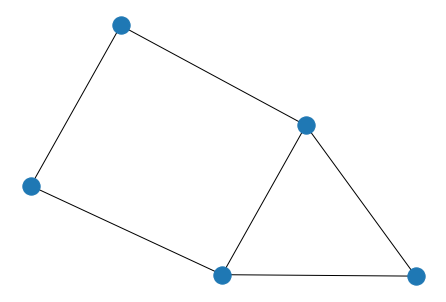

In [4]:
G = nx.Graph([[1,2],[2,3],[3,4],[4,1],[4,5],[3,5]])
nx.draw(G)

In [5]:
ex_1 = NBEigVals(G)

In [6]:
ex_1.check_all_vals(1e-8,y_formula=True)


		--------------------1---------------------

mu: (1.4240542207409415+0j)
	0 - Positive: True	Negative:False
	1 - Positive: True	Negative:False
	2 - Positive: True	Negative:False
	3 - Positive: True	Negative:False
	4 - Positive: True	Negative:False

		--------------------2---------------------

mu: (1.0000000000000002+0j)
	0 - Positive: False	Negative:True
	1 - Positive: False	Negative:True
	2 - Positive: False	Negative:True
	3 - Positive: False	Negative:True
	4 - Positive: False	Negative:True

		--------------------3---------------------

mu: (0.34779178733274685+0.9739246927763867j)
	0 - Positive: True	Negative:False
	1 - Positive: True	Negative:False
	2 - Positive: True	Negative:False
	3 - Positive: True	Negative:False
	4 - Positive: True	Negative:False

		--------------------4---------------------

mu: (0.34779178733274685-0.9739246927763867j)
	0 - Positive: True	Negative:False
	1 - Positive: True	Negative:False
	2 - Positive: True	Negative:False
	3 - Positive: True	Negative:False

In [7]:
ex_1.linear_combinations()

[ 9.92727173e-01+0.j  5.11356496e-16+0.j  8.29597966e-02+0.j
 -5.34619942e-16+0.j  8.72377883e-02+0.j]
[-9.84957965e-01+0.j -5.03577144e-16-0.j -1.22343209e-01+0.j
  4.26494204e-16+0.j -1.22024368e-01+0.j]
[ 3.02906071e-02-1.03069203e-01j  1.02928748e-15+6.99526007e-16j
 -1.00818847e+00-4.63679210e-03j -4.45628134e-16-6.88223190e-18j
  1.84818586e-02-8.40138213e-02j]
[ 3.02906071e-02+1.03069203e-01j  1.02928748e-15-6.99526007e-16j
 -1.00818847e+00+4.63679210e-03j -4.45628134e-16+6.88223190e-18j
  1.84818586e-02+8.40138213e-02j]
[-4.19031860e-16-2.09515930e-16j  9.89281437e-01-1.95352593e-02j
 -6.76452987e-16+6.56557311e-16j -1.81703538e-01-1.06359346e-01j
  1.02589984e-17+4.10359935e-17j]
[-4.19031860e-16+2.09515930e-16j  9.89281437e-01+1.95352593e-02j
 -6.76452987e-16-6.56557311e-16j -1.81703538e-01+1.06359346e-01j
  1.02589984e-17-4.10359935e-17j]
[ 9.65737489e-17+7.85684737e-17j  8.80678766e-03+2.17575760e-01j
 -3.18330817e-16+7.23394347e-16j  1.02335974e+00-1.87240463e-03j
  8.2071

In [8]:
np.allclose(ex_1.x_matrix@ex_1.x_matrix.T@ex_1.y_matrix,ex_1.y_matrix)

True

In [9]:
ex_1.x_matrix@ex_1.x_matrix.T

array([[ 1.00000000e+00, -6.05485968e-17, -1.21829941e-16,
        -4.16078197e-16, -1.08081673e-16],
       [-6.05485968e-17,  1.00000000e+00,  4.54641932e-17,
        -2.76539639e-16,  2.20137136e-16],
       [-1.21829941e-16,  4.54641932e-17,  1.00000000e+00,
         1.71108466e-16,  2.19879893e-17],
       [-4.16078197e-16, -2.76539639e-16,  1.71108466e-16,
         1.00000000e+00,  2.29557436e-16],
       [-1.08081673e-16,  2.20137136e-16,  2.19879893e-17,
         2.29557436e-16,  1.00000000e+00]])

In [10]:
np.round(ex_1.conv_matrix,6).shape

(5, 10)

In [11]:
ex_1.K

array([[ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [-1., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -1., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -1., -0., -0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -1., -0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0., -1.,  0.,  0.,  0.,  0.,  0.]])

In [12]:
for i in range(ex_1.y_matrix.shape[1]):
    print(np.abs(ex_1.y_matrix[:,i]@ex_1.y_matrix[:,i]))

1.0
0.9999999999999998
0.9999999999999998
0.9999999999999998
1.0000000000000002
1.0000000000000002
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999


In [13]:
ex_1.y_matrix

array([[ 4.20357655e-01+0.00000000e+00j, -4.47213595e-01+0.00000000e+00j,
        -5.66651356e-01-5.62895237e-02j, -5.66651356e-01+5.62895237e-02j,
         5.85492488e-01+4.34120431e-02j,  5.85492488e-01-4.34120431e-02j,
        -5.07276476e-01+1.09724082e-01j, -5.07276476e-01-1.09724082e-01j,
        -2.00050956e-01+6.96051845e-03j, -2.00050956e-01-6.96051845e-03j],
       [ 4.20357655e-01+0.00000000e+00j, -4.47213595e-01+0.00000000e+00j,
        -5.66651356e-01-5.62895237e-02j, -5.66651356e-01+5.62895237e-02j,
        -5.85492488e-01-4.34120431e-02j, -5.85492488e-01+4.34120431e-02j,
         5.07276476e-01-1.09724082e-01j,  5.07276476e-01+1.09724082e-01j,
        -2.00050956e-01+6.96051845e-03j, -2.00050956e-01-6.96051845e-03j],
       [ 4.73438181e-01+0.00000000e+00j, -4.47213595e-01+0.00000000e+00j,
         1.88864710e-01-1.74498687e-02j,  1.88864710e-01+1.74498687e-02j,
         4.03788949e-01-6.29473024e-02j,  4.03788949e-01+6.29473024e-02j,
         5.16083264e-01+1.07851678e-

In [14]:
np.round(ex_1.x_matrix,6)

array([[ 0.357751,  0.5     ,  0.576451, -0.5     ,  0.199295],
       [ 0.357751, -0.5     ,  0.576451,  0.5     ,  0.199295],
       [ 0.529899,  0.5     , -0.179338,  0.5     , -0.432487],
       [ 0.529899, -0.5     , -0.179338, -0.5     , -0.432487],
       [ 0.427132, -0.      , -0.520657,  0.      ,  0.739239]])

# Example 2

In [15]:
G = nx.cycle_graph(6)

In [16]:
ex_2 = NBEigVals(G)
ex_2.check_all_vals(1e-8)


		--------------------1---------------------

mu: (-1.0000000000000013+6.452392069879467e-09j)
	0 - Positive: False	Negative:False	x^Ty=(1-2.0203809154758067e-39j)
	1 - Positive: False	Negative:False	x^Ty=(-3.3306690738754696e-16-1.313325610646309e-24j)
	2 - Positive: False	Negative:False	x^Ty=(-1.8528428642149643e-16+1.0130852129388735e-24j)
	3 - Positive: False	Negative:False	x^Ty=(8.471933673360674e-17+3.6428257236111514e-24j)
	4 - Positive: False	Negative:False	x^Ty=(-3.706442707934476e-17+1.7226827042297432e-24j)
	5 - Positive: False	Negative:False	x^Ty=(1.464781954913539e-16+4.046110771037276e-25j)

		--------------------2---------------------

mu: (-1.0000000000000013-6.452392069879467e-09j)
	0 - Positive: False	Negative:False	x^Ty=(1+2.0203809154758067e-39j)
	1 - Positive: False	Negative:False	x^Ty=(-3.3306690738754696e-16+1.313325610646309e-24j)
	2 - Positive: False	Negative:False	x^Ty=(-1.8528428642149643e-16-1.0130852129388735e-24j)
	3 - Positive: False	Negative:False	x^Ty=

In [17]:
ex_2.linear_combinations()

[ 1.00000000e+00-2.24950106e-40j -3.62597321e-16-1.31332561e-24j
  1.04006314e-16+1.11374398e-24j  3.59398112e-16+3.48273375e-24j
  8.03052483e-17+1.29070275e-24j  1.40817935e-16+5.93503218e-25j]
[ 1.00000000e+00+2.24950106e-40j -3.62597321e-16+1.31332561e-24j
  1.04006314e-16-1.11374398e-24j  3.59398112e-16-3.48273375e-24j
  8.03052483e-17-1.29070275e-24j  1.40817935e-16-5.93503218e-25j]
[ 2.26623326e-15+5.36827083e-16j  1.74315280e-31-1.68259235e-16j
  6.40987562e-16-3.35958180e-16j  1.00116626e+00-1.24445370e-17j
 -9.78252678e-03+1.08778774e-16j  6.33680708e-17-9.95733169e-18j]
[ 2.26623326e-15-5.36827083e-16j  1.74315280e-31+1.68259235e-16j
  6.40987562e-16+3.35958180e-16j  1.00116626e+00+1.24445370e-17j
 -9.78252678e-03-1.08778774e-16j  6.33680708e-17+9.95733169e-18j]
[ 0.00000000e+00-2.14907827e-24j -1.00000000e+00-1.19393237e-24j
 -3.07550698e-16+2.83793811e-24j -2.11807850e-16+7.43609841e-25j
 -1.09686364e-16-5.96036130e-25j -1.12654348e-16-1.18700644e-24j]
[ 0.00000000e+00+2.1

# Example 3

In [18]:
G = nx.Graph([[1,2],[2,3],[3,1],[3,4],[4,5],[5,3]])
ex_3 = NBEigVals(G)
ex_3.check_all_vals(1e-8)


		--------------------1---------------------

mu: (-0.7211247851537032+1.2490247664834078j)
	0 - Positive: False	Negative:True	x^Ty=(0.0813542483374671+0.15393848671502577j)
	1 - Positive: False	Negative:False	x^Ty=(1.8402967841046425e-16-4.816254932798387e-16j)
	2 - Positive: False	Negative:False	x^Ty=(1.5345963680453675e-15-3.3270359089500667e-18j)
	3 - Positive: True	Negative:False	x^Ty=(1.0085795587306743-0.012417017347316981j)
	4 - Positive: False	Negative:False	x^Ty=(3.947519319907931e-16+1.851711557370277e-16j)

		--------------------2---------------------

mu: (-0.7211247851537032-1.2490247664834078j)
	0 - Positive: False	Negative:True	x^Ty=(0.0813542483374671-0.15393848671502577j)
	1 - Positive: False	Negative:False	x^Ty=(1.8402967841046425e-16+4.816254932798387e-16j)
	2 - Positive: False	Negative:False	x^Ty=(1.5345963680453675e-15+3.3270359089500667e-18j)
	3 - Positive: True	Negative:False	x^Ty=(1.0085795587306743+0.012417017347316981j)
	4 - Positive: False	Negative:False	x^

# Example 4

In [19]:
G = nx.complete_graph(4)
ex_4 = NBEigVals(G)
ex_4.check_all_vals(1e-8)


		--------------------1---------------------

mu: (2.000000000000001+0j)
	0 - Positive: False	Negative:False	x^Ty=(5.551115123125783e-17+0j)
	1 - Positive: False	Negative:True	x^Ty=(-1+0j)
	2 - Positive: False	Negative:False	x^Ty=(5.551115123125783e-17+0j)
	3 - Positive: False	Negative:False	x^Ty=0j

		--------------------2---------------------

mu: (1.0000000000000004+0j)
	0 - Positive: False	Negative:False	x^Ty=0j
	1 - Positive: False	Negative:True	x^Ty=(1+0j)
	2 - Positive: False	Negative:False	x^Ty=0j
	3 - Positive: False	Negative:False	x^Ty=(-5.551115123125783e-17+0j)

		--------------------3---------------------

mu: (-0.49999999999999994+1.3228756555322956j)
	0 - Positive: False	Negative:True	x^Ty=(-0.9955117081751313+0.004806026229698298j)
	1 - Positive: False	Negative:False	x^Ty=(5.551115123125783e-17+0j)
	2 - Positive: True	Negative:False	x^Ty=(0.1349232682593311-0.038765025250195755j)
	3 - Positive: False	Negative:True	x^Ty=(0.0032884706447225687+0.05931337727915687j)

		--

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in cdouble_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in cdouble_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in cdouble_scalars


In [20]:
ex_4.conv_matrix

array([[ 5.55111512e-17+0.00000000e+00j, -2.77555756e-17+0.00000000e+00j,
        -9.95511708e-01+4.80602623e-03j, -9.95511708e-01-4.80602623e-03j,
        -6.02096488e-02-2.01543727e-01j, -6.02096488e-02+2.01543727e-01j,
         2.09452195e-01+6.39683171e-02j,  2.09452195e-01-6.39683171e-02j],
       [-1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
         2.77555756e-17+0.00000000e+00j,  2.77555756e-17+0.00000000e+00j,
        -1.38777878e-16-3.33066907e-16j, -1.38777878e-16+3.33066907e-16j,
         1.38777878e-17-3.60822483e-16j,  1.38777878e-17+3.60822483e-16j],
       [ 5.55111512e-17+0.00000000e+00j, -2.77555756e-17+0.00000000e+00j,
         1.34923268e-01-3.87650253e-02j,  1.34923268e-01+3.87650253e-02j,
        -1.05069777e+00+1.61029908e-01j, -1.05069777e+00-1.61029908e-01j,
        -6.16057584e-01+2.15109626e-01j, -6.16057584e-01-2.15109626e-01j],
       [ 0.00000000e+00+0.00000000e+00j, -5.55111512e-17+0.00000000e+00j,
         3.28847064e-03+5.93133773e

In [21]:
ex_4.x_matrix

array([[-0.8660254 ,  0.5       ,  0.21699376,  0.        ],
       [ 0.28867513,  0.5       , -0.86278187,  0.        ],
       [ 0.28867513,  0.5       ,  0.32289406, -0.70710678],
       [ 0.28867513,  0.5       ,  0.32289406,  0.70710678]])

In [22]:
ex_4.y_matrix

array([[-0.5       +0.j        ,  0.5       +0.j        ,
         0.86213843-0.00416214j,  0.86213843+0.00416214j,
         0.05214309+0.17454199j,  0.05214309-0.17454199j,
        -0.18139092-0.05539819j, -0.18139092+0.05539819j],
       [-0.5       +0.j        ,  0.5       +0.j        ,
        -0.19079749+0.0330662j , -0.19079749-0.0330662j ,
         0.88150208-0.15140221j,  0.88150208+0.15140221j,
         0.53578463-0.17647566j,  0.53578463+0.17647566j],
       [-0.5       +0.j        ,  0.5       +0.j        ,
        -0.33799577-0.05639292j, -0.33799577+0.05639292j,
        -0.63784229-0.34357266j, -0.63784229+0.34357266j,
         0.41476445+0.22201779j,  0.41476445-0.22201779j],
       [-0.5       +0.j        ,  0.5       +0.j        ,
        -0.33334517+0.02748886j, -0.33334517-0.02748886j,
        -0.29580287+0.32043288j, -0.29580287-0.32043288j,
        -0.76915816+0.00985606j, -0.76915816-0.00985606j]])

In [23]:
ex_4.K

array([[ 0.,  1.,  1.,  1.,  2.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  1.,  0.,  2.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  0.,  0.,  2.,  0.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  2.],
       [-1., -0., -0., -0.,  0.,  0.,  0.,  0.],
       [-0., -1., -0., -0.,  0.,  0.,  0.,  0.],
       [-0., -0., -1., -0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -1.,  0.,  0.,  0.,  0.]])

In [24]:
lambda_ = lambda mu, d: mu+1/mu*(d-1)

In [25]:
ex_4.lambda_vals

array([-1.+0.j,  3.+0.j, -1.+0.j, -1.+0.j])

In [26]:
for mu in ex_4.mu_vals:
    print(lambda_(mu,3))

(3.0000000000000004+0j)
(2.9999999999999996+0j)
(-0.9999999999999998+4.440892098500626e-16j)
(-0.9999999999999998-4.440892098500626e-16j)
(-1.0000000000000002-6.661338147750939e-16j)
(-1.0000000000000002+6.661338147750939e-16j)
(-0.9999999999999993+0j)
(-0.9999999999999993+0j)


# Example 5

In [27]:
np.allclose(ex_5.y_matrix[:,0],ex_5.y_matrix[:,3])

NameError: name 'ex_5' is not defined

In [ ]:
vals, vecs = la.eig(ex_5.K)
np.allclose(vecs@np.diag(vals)@la.inv(vecs),ex_5.K)

In [ ]:
np.round(ex_5.kvecs,6).T@np.round(ex_5.kvecs,6)

In [ ]:
la.inv(np.round(ex_5.x_matrix,6))

In [ ]:
ex_5.mu_vals

# find function y=f(x)

In [ ]:
mu_0 = ex_1.mu_vals[0]
y0 = ex_1.y_matrix[:,0]

In [ ]:
mu_0**2*y0-mu_0*ex_1.A@y0+(ex_1.D-ex_1.I)@y0

In [ ]:
lambda_0 = ex_1.lambda_vals[0]
x0 = ex_1.x_matrix[:,0]

In [ ]:
mu_0**2*x0-mu_0*ex_1.A@x0+(ex_1.D-ex_1.I)@x0

In [ ]:
for _ in range(10):
    g = nx.gnp_random_graph(50,.5)
    ex = NBEigVals(g)
    length = len(np.unique(ex.mu_vals))
    if length == len(ex.mu_vals):
        print('Unique')
    else:
        print(length)
        print(ex.mu_vals)
    

In [ ]:
def create_diagonalizing_matrix(lambda_vals,x_matrix,A):
    X = np.vstack((-A@x_matrix,x_matrix))
    return X

In [ ]:
create_diagonalizing_matrix(ex_5.lambda_vals,ex_5.x_matrix,ex_5.A)

In [ ]:
np.round(ex_5.y_matrix.T@ex_5.y_matrix,5)

In [ ]:
X = (np.hstack((ex_5.x_matrix,ex_5.x_matrix))@-np.diag(ex_5.mu_vals))

In [ ]:
for i in range(X.shape[1]):
    X[:,i] = X[:,i]/np.sqrt(X[:,i]@X[:,i])

In [ ]:
ex_5.y_matrix

In [ ]:
ex_5.mu_vals

In [ ]:
ex_5.check_all_vals(1e-8)

In [ ]:
ex_5.lambda_vals

In [ ]:
for val in ex_5.mu_vals:
    print(val+1/val*(4-1))

In [ ]:
for i in range(ex_5.K.shape[1]):
    print(ex_5.mu_vals[i],'\n',ex_5.kvecs[:,i])

In [ ]:
np.allclose(ex_5.kvecs[ex_5.K.shape[0]//2:,:],ex_5.y_matrix)

In [ ]:
np.allclose(X,ex_5.kvecs)

$K=V^{-1}XV$

In [ ]:
np.allclose(la.inv(ex_5.kvecs)@np.diag(ex_5.mu_vals)@ex_5.kvecs,ex_5.K)

In [ ]:
la.eigvals(la.inv(np.diag(ex_5.C.sum(axis=1))-np.eye(ex_5.C.shape[0]))@ex_5.B)

In [ ]:
nx.bipartite.is_bipartite(ex_5.G)

In [ ]:
G = nx.random_regular_graph(4,6)
ex_5 = NBEigVals(G)
ex_5.check_all_vals(1e-8)

##### nx.draw(ex_5.G)

In [ ]:
np.allclose(ex_5.K,la.inv(ex_5.kvecs)@np.diag(ex_5.mu_vals)@ex_5.kvecs)

In [ ]:
kvals, kvecs = la.eig(ex_5.K)

In [ ]:
np.allclose(ex_5.K,la.inv(kvecs)@np.diag(ex_5.mu_vals)@kvecs)

In [ ]:
plt.imshow(ex_5.K)

In [ ]:
plt.imshow(np.real(la.inv(kvecs)@np.diag(ex_5.mu_vals)@kvecs))